### Install Packages

In [48]:
# !pip install numpy
# !pip install opencv-python
# !pip install pillow
# !pip install matplotlib
# !pip install tqdm
# !pip install scikit-learn
# !pip install torch torchvision
# !pip install ultralytics



In [49]:
# Core packages
import os
import shutil
import json
import zipfile
import xml.etree.ElementTree as ET
from pathlib import Path

# Math and array handling
import numpy as np
from sklearn.model_selection import train_test_split

# Image and visualization
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Progress bar
from tqdm.auto import tqdm

# Deep Learning Frameworks
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.models.segmentation as segmentation
import torchvision.transforms as transforms

# Object Detection and Segmentation
from ultralytics import YOLO

from torch.utils.data import DataLoader
import gc

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline





### Download Datasets

In [50]:
import gdown
import zipfile
import os

def download_and_extract_from_gdrive(gdrive_url, extract_to="extracted"):
    # Convert shared drive URL to direct download URL
    file_id = gdrive_url.split("/d/")[1].split("/")[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Create output folder
    os.makedirs(extract_to, exist_ok=True)

    zip_path = os.path.join(extract_to, "downloaded.zip")

    print("[INFO] Downloading ZIP from Google Drive...")
    gdown.download(download_url, zip_path, quiet=False)

    print("[INFO] Extracting ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_path)

    print(f"[DONE] Extracted files to: {extract_to}")



### Convert downloaded Dataset into yolo format

In [51]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import json
from tqdm.auto import tqdm



# Function to parse XML files for bounding boxes (YOLO annotations)
def parse_bbox_xml(xml_path, class_id_to_name):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in [value[0] for value in class_id_to_name.values()]:  # Only the specified classes
            polygon = obj.find('polygon')
            if polygon is not None:
                points = polygon.findall('pt')
                coords = [(float(pt.find('x').text), float(pt.find('y').text)) for pt in points]
                # Get bounding box (min, max x and y)
                x_min = min([coord[0] for coord in coords])
                y_min = min([coord[1] for coord in coords])
                x_max = max([coord[0] for coord in coords])
                y_max = max([coord[1] for coord in coords])
                bboxes.append(((x_min, y_min), (x_max, y_max), class_name))
    return bboxes

# Function to parse XML files for segmentation polygons (mask annotations)
def parse_segmentation_xml(xml_path, class_id_to_name):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in [value[0] for value in class_id_to_name.values()]:  # Only the specified classes
            polygon = obj.find('polygon')
            if polygon is not None:
                points = polygon.findall('pt')
                coords = [(float(pt.find('x').text), float(pt.find('y').text)) for pt in points]
                # Get bounding box (min, max x and y)
                x_min = min([coord[0] for coord in coords])
                y_min = min([coord[1] for coord in coords])
                x_max = max([coord[0] for coord in coords])
                y_max = max([coord[1] for coord in coords])
                bboxes.append(((x_min, y_min), (x_max, y_max), class_name))
    return bboxes

# Function to create a segmentation mask based on the class color mapping
def create_segmentation_mask(image_size, bboxes, class_id_to_name):
    segmentation_mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    for (x_min, y_min), (x_max, y_max), class_name in bboxes:
        class_id, class_rgb = next(((cid, rgb) for cid, (name, rgb) in class_id_to_name.items() if name == class_name), (None, None))
        if class_rgb is not None:
            segmentation_mask[int(y_min):int(y_max), int(x_min):int(x_max)] = class_rgb
    return segmentation_mask

# Function to save annotations in YOLO format
def save_yolo_format(image_id, bboxes, image_width, image_height, output_path, class_id_to_name):
    with open(output_path, 'w') as f:
        for (x_min, y_min), (x_max, y_max), class_name in bboxes:
            class_id = next(cid for cid, (name, _) in class_id_to_name.items() if name == class_name)
            # Normalize bounding box coordinates
            x_center = (x_min + x_max) / 2 / image_width
            y_center = (y_min + y_max) / 2 / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

def convert_fulldataset(dataset_path, output_dir, class_id_to_name):
    # Loop through all the images in the dataset
    image_ids = [img.split('.')[0] for img in os.listdir(f"{dataset_path}/images") if img.endswith(".jpg")]

    # Create the output directory structure if it doesn't exist
    os.makedirs(f"{output_dir}/images", exist_ok=True)
    os.makedirs(f"{output_dir}/segmentation_mask", exist_ok=True)
    os.makedirs(f"{output_dir}/labels", exist_ok=True)

    # Process each image
    for image_id in tqdm(image_ids):
        img_path = f"{dataset_path}/images/{image_id}.jpg"
        xml_bbox_path = f"{dataset_path}/gt/bounding_box/label_me_xml/{image_id}.xml"
        xml_mask_path = f"{dataset_path}/gt/semantic/label_me_xml/{image_id}.xml"

        # Check if image file exists
        if not os.path.exists(img_path):
            print(f"[WARNING] Image not found: {img_path}, skipping...")
            continue

        # Try parsing bounding box and mask annotations
        try:
            bboxes = parse_bbox_xml(xml_bbox_path, class_id_to_name)  # for YOLO annotation
            mask_boxes = parse_segmentation_xml(xml_mask_path, class_id_to_name)  # for segmentation mask
        except Exception as e:
            print(f"[WARNING] Skipping image {image_id} due to parse error: {e}")
            continue

        # Load image
        try:
            image = Image.open(img_path)
            image = np.array(image)
        except Exception as e:
            print(f"[WARNING] Could not load image {image_id}: {e}")
            continue

        # Create segmentation mask from polygons
        image_size = image.shape[:2]
        segmentation_mask = create_segmentation_mask(image_size, mask_boxes, class_id_to_name)

        # Save original image
        image_pil = Image.fromarray(image)
        image_pil.save(f"{output_dir}/images/{image_id}.jpg")

        # Save segmentation mask
        segmentation_mask_image = Image.fromarray(segmentation_mask)
        segmentation_mask_image.save(f"{output_dir}/segmentation_mask/{image_id}_segmentation_mask.png")

        # Save YOLO annotations (bounding boxes)
        yolo_annotation_path = f"{output_dir}/labels/{image_id}.txt"
        save_yolo_format(image_id, bboxes, image_size[1], image_size[0], yolo_annotation_path, class_id_to_name)

        print("[+] Processing completed for all images.")


### Visualizing images with bounding boxes and segmentation masks

In [52]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Path to the dataset
dataset_path = "./datasets/new_dataset"
image_dir = os.path.join(dataset_path, "images")
segmentation_mask_dir = os.path.join(dataset_path, "segmentation_mask")
annotations_dir = os.path.join(dataset_path, "labels")


# Function to load YOLO bounding box annotations
def load_yolo_annotations(anno_file):
    with open(anno_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to visualize the segmentation mask and bounding boxes
def visualize_data(image_id, class_id_to_name):
    # Load image
    img_path = os.path.join(image_dir, f"{image_id}.jpg")
    segmentation_mask_path = os.path.join(segmentation_mask_dir, f"{image_id}_segmentation_mask.png")
    annotation_path = os.path.join(annotations_dir, f"{image_id}.txt")
    
    if not os.path.exists(img_path) or not os.path.exists(segmentation_mask_path) or not os.path.exists(annotation_path):
        print(f"[WARNING] Missing files for {image_id}, skipping...")
        return

    # Load image and segmentation mask
    image = Image.open(img_path)
    image = np.array(image)
    segmentation_mask = Image.open(segmentation_mask_path)
    segmentation_mask = np.array(segmentation_mask)

    # Load YOLO annotations
    boxes = load_yolo_annotations(annotation_path)

    # Plotting the image with bounding boxes and segmentation mask overlay
    plt.figure(figsize=(15, 10))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image: {image_id}")
    
    # Plot segmentation mask with overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(segmentation_mask, alpha=0.7)  # Overlay segmentation mask with transparency
    plt.title(f"Segmentation Mask: {image_id}")

    # Draw bounding boxes on the image
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        class_name = class_id_to_name[int(class_id)][0]
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        # Draw bounding box
        color = class_id_to_name[int(class_id)][1]
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 16)
    
    # Show the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Image with Bounding Boxes: {image_id}")

    # Add color legend to indicate class-to-color mapping
    legend_handles = []
    for class_id, (class_name, class_rgb) in class_id_to_name.items():
        color = np.array(class_rgb) / 255.0  # Normalize to [0, 1] range for plotting
        legend_handles.append(mpatches.Patch(color=color, label=f"{class_name} ({class_id})"))
    
    plt.legend(handles=legend_handles, loc='upper right', fontsize=10)
    plt.show()


### Convert into train set and val set 

In [53]:
def move_files(file_list, source_image_dir, source_mask_dir, source_annotation_dir,
               target_image_dir, target_mask_dir, target_annotation_dir):
    for image_id in tqdm(file_list, desc="Moving files"):
        image_path = os.path.join(source_image_dir, f"{image_id}.jpg")
        mask_path = os.path.join(source_mask_dir, f"{image_id}_segmentation_mask.png")
        annotation_path = os.path.join(source_annotation_dir, f"{image_id}.txt")

        # Move image file
        if os.path.exists(image_path):
            shutil.copy(image_path, target_image_dir)
        
        # Move segmentation mask file
        if os.path.exists(mask_path):
            shutil.copy(mask_path, target_mask_dir)
        
        # Move YOLO annotation file
        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, target_annotation_dir)

### Training 

In [54]:
def train_yolo(data_yaml="uavdt.yaml", epochs=40, imgsz=640, batch=32, name="yolov8-uavdt"):
    model = YOLO("yolov8n.pt")
    model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        show=True,
        name=name,
        project="runs/train"
    )


# ----------------------------
# 2. Segmentation Dataset Class
# ----------------------------
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

        self.class_id_to_name = {
            0: ('road', [28, 42, 168]),
            1: ('pool', [0, 50, 89]),
            2: ('vegetation', [107, 142, 35]),
            3: ('roof', [70, 70, 70]),
            4: ('wall', [102, 102, 156]),
            5: ('window', [254, 228, 12]),
            6: ('person', [255, 22, 96]),
            7: ('dog', [102, 51, 0]),
            8: ('car', [9, 143, 150]),
            9: ('bicycle', [119, 11, 32]),
            10: ('tree', [51, 51, 0]),
        }

        self.class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(self.class_id_to_name.keys())}
        self.class_names = [name[0] for name in self.class_id_to_name.values()]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert('RGB').resize((256, 256))
        mask = Image.open(mask_path).convert('RGB').resize((256, 256))
        mask = self.convert_mask_to_class_ids(np.array(mask))

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def convert_mask_to_class_ids(self, mask):
        class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        for class_id, (_, color) in self.class_id_to_name.items():
            color_mask = np.all(mask == color, axis=-1)
            class_mask[color_mask] = self.class_id_map[class_id]
        return class_mask


# ----------------------------
# 3. Segmentation Training Function
# ----------------------------
def train_segmentation(image_dir, mask_dir, epochs=1, batch_size=8, save_path="deeplabv3_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    dataset = SegmentationDataset(image_dir, mask_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.classifier[4] = nn.Conv2d(256, len(dataset.class_names), kernel_size=1)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            output = model(images)['out']
            loss = criterion(output, masks)
            loss.backward()
            optimizer.step()

            gc.collect()
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dataloader):.4f}")

    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to {save_path}")


### Finding best model path

In [55]:
def find_best_pt(base_dir='runs/'):
    best_paths = list(Path(base_dir).rglob('best.pt'))
    if not best_paths:
        raise FileNotFoundError("No 'best.pt' file found in the 'runs/' directory.")
    
    # Optionally, sort by latest modified time
    best_paths.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    
    print(f"✅ Found best.pt at: {best_paths[0]}")
    return str(best_paths[0])


### Prediciton on val images

In [56]:

# ---------- FUNCTIONS ----------

def load_deeplabv3_model(weight_path: str):
    model = segmentation.deeplabv3_resnet101(pretrained=False)
    model.classifier[4] = nn.Conv2d(256, 11, kernel_size=(1, 1))  # 11 classes
    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.to(device).eval()
    return model

def load_yolo_model(weight_path: str):
    return YOLO(weight_path)

def run_segmentation(model, image: Image.Image):
    transform = transforms.ToTensor()
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)['out']
        seg_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return seg_mask

def decode_segmentation_mask(seg_mask, CLASS_COLORS):
    seg_rgb = np.zeros((seg_mask.shape[0], seg_mask.shape[1], 3), dtype=np.uint8)
    for cls_id, color in CLASS_COLORS.items():
        seg_rgb[seg_mask == cls_id] = (np.array(color) * 255).astype(np.uint8)
    return Image.fromarray(seg_rgb)

def run_yolo(model, image: Image.Image):
    temp_path = "temp_resized.jpg"
    image.save(temp_path)
    result = model.predict(source=temp_path, conf=0.3, save=False, verbose=False)[0]
    os.remove(temp_path)
    return result

def draw_yolo_boxes(draw: ImageDraw.ImageDraw, result):
    boxes = result.boxes
    labels = result.names
    for i in range(len(boxes)):
        box = boxes.xyxy[i].cpu().numpy()
        cls_id = int(boxes.cls[i])
        conf = float(boxes.conf[i])
        label = f"{labels[cls_id]} {conf:.2f}"
        draw.rectangle(box, outline="red", width=1)
        draw.text((box[0], box[1]), label, fill="red")

def plot_results(blended_img, seg_mask, CLASS_COLORS, CLASS_NAMES):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(blended_img)
    axs[0].set_title("YOLO + DeepLabV3 Overlay")
    axs[0].axis("off")

    axs[1].imshow(np.zeros((256, 256, 3), dtype=np.uint8))
    axs[1].axis("off")
    axs[1].set_title("Segmentation Class Legend")
    for idx, cls_id in enumerate(np.unique(seg_mask)):
        color = CLASS_COLORS.get(cls_id, (1, 1, 1))
        label = f"{cls_id}: {CLASS_NAMES.get(cls_id, 'unknown')}"
        axs[1].add_patch(plt.Rectangle((10, 10 + idx * 25), 20, 20, color=color))
        axs[1].text(35, 25 + idx * 25, label, fontsize=10, va='center', color="white")
    plt.tight_layout()
    plt.show()

def predict_and_visualize(image_path, deeplab_model, yolo_model, CLASS_COLORS, CLASS_NAMES):
    original_image = Image.open(image_path).convert("RGB")
    resized_image = original_image.resize((256, 256))

    # Segmentation
    seg_mask = run_segmentation(deeplab_model, resized_image)
    seg_overlay = decode_segmentation_mask(seg_mask, CLASS_COLORS)

    # Blend image + overlay
    blended = Image.blend(resized_image, seg_overlay, alpha=0.5)
    draw = ImageDraw.Draw(blended)

    # YOLO
    yolo_result = run_yolo(yolo_model, resized_image)
    draw_yolo_boxes(draw, yolo_result)

    # Plot
    plot_results(blended, seg_mask, CLASS_COLORS, CLASS_NAMES)



### Predcitions on videos

In [57]:

output_base = './video_outputs'


# ================== OUTPUT FOLDERS ==================
img_dir = os.path.join(output_base, 'images')
seg_dir = os.path.join(output_base, 'segmentation_mask')
label_dir = os.path.join(output_base, 'labels')
video_output_path = os.path.join(output_base, 'output_video.mp4')

os.makedirs(img_dir, exist_ok=True)
os.makedirs(seg_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# ================== LOAD MODELS ==================
def load_models(yolo_weights_path, deeplabv3_weights_path, num_classes):
    yolo_model = YOLO(yolo_weights_path)
    deeplab = models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=num_classes, aux_loss=True)
    state_dict = torch.load(deeplabv3_weights_path, map_location=device)
    for k in list(state_dict.keys()):
        if k.startswith("aux_classifier."):
            del state_dict[k]
    deeplab.load_state_dict(state_dict, strict=False)
    deeplab.to(device)
    deeplab.eval()
    return yolo_model, deeplab

# ================== IMAGE TRANSFORM ==================
def get_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

# ================== COLOR MASK ==================
def get_colored_mask(mask, class_id_to_name):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls_id, (_, color) in class_id_to_name.items():
        color_mask[mask == cls_id] = color
    return color_mask

# ================== PROCESS FRAME ==================
def process_frame(frame, deeplab, yolo_model, transform, w, h, yolo_class_names, class_id_to_name):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    # === Segmentation ===
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = deeplab(input_tensor)['out']
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    mask_resized = cv2.resize(pred_mask.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
    mask_colored = get_colored_mask(mask_resized, class_id_to_name)

    # === YOLO Detection ===
    results = yolo_model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()

    for box, cls_id in zip(boxes, class_ids):
        x1, y1, x2, y2 = map(int, box)
        name = yolo_class_names[int(cls_id)] if int(cls_id) < len(yolo_class_names) else f"Class {int(cls_id)}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, name, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    return frame_rgb, mask_colored, boxes, class_ids

# ================== SAVE OUTPUTS ==================
def save_outputs(frame_rgb, mask_colored, boxes, class_ids, frame_count, w, h, img_dir, seg_dir, label_dir, yolo_class_names):
    # Save original frame
    out_img = os.path.join(img_dir, f'frame_{frame_count:04d}.jpg')
    out_mask = os.path.join(seg_dir, f'mask_{frame_count:04d}.png')
    out_label = os.path.join(label_dir, f'frame_{frame_count:04d}.txt')

    # Save original frame
    cv2.imwrite(out_img, frame_rgb[..., ::-1])  # RGB -> BGR

    # Save colored segmentation mask
    cv2.imwrite(out_mask, mask_colored)

    # Save YOLO labels
    with open(out_label, 'w') as f:
        for box, cls_id in zip(boxes, class_ids):
            x1, y1, x2, y2 = box
            w_box = x2 - x1
            h_box = y2 - y1
            cx = x1 + w_box / 2
            cy = y1 + h_box / 2
            cx /= w
            cy /= h
            w_box /= w
            h_box /= h
            f.write(f"{int(cls_id)} {cx:.6f} {cy:.6f} {w_box:.6f} {h_box:.6f}  # {yolo_class_names[int(cls_id)]}\n")

# ================== VIDEO SETUP ==================
def setup_video_capture(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    return cap, total_frames, fps, w, h, fourcc

# ================== MAIN VIDEO PROCESSING ==================
def process_video(video_path, yolo_weights_path, deeplabv3_weights_path, yolo_class_names, class_id_to_name, num_classes, max_frames=None, ):
    yolo_model, deeplab = load_models(yolo_weights_path, deeplabv3_weights_path, num_classes)
    transform = get_transform()
    
    cap, total_frames, fps, w, h, fourcc = setup_video_capture(video_path)
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (w, h))
    
    frame_count = 0
    pbar = tqdm(total=max_frames if max_frames else total_frames, desc="Processing", leave=False)

    while True:
        ret, frame = cap.read()
        if not ret or (max_frames is not None and frame_count >= max_frames):
            break

        frame_rgb, mask_colored, boxes, class_ids = process_frame(frame, deeplab, yolo_model, transform, w, h, yolo_class_names, class_id_to_name)
        save_outputs(frame_rgb, mask_colored, boxes, class_ids, frame_count, w, h, img_dir, seg_dir, label_dir, yolo_class_names)

        blended = cv2.addWeighted(frame, 1.0, mask_colored, 0.5, 0)
        video_writer.write(blended)

        frame_count += 1
        pbar.update(1)

    cap.release()
    video_writer.release()
    pbar.close()

    print(f"\nDone! Processed {frame_count} frames.")



### Print Metrics

### Retrain and Quantization

### Full Pipeline

✅ Found best.pt at: runs\train\yolov8-uavdt\weights\best.pt


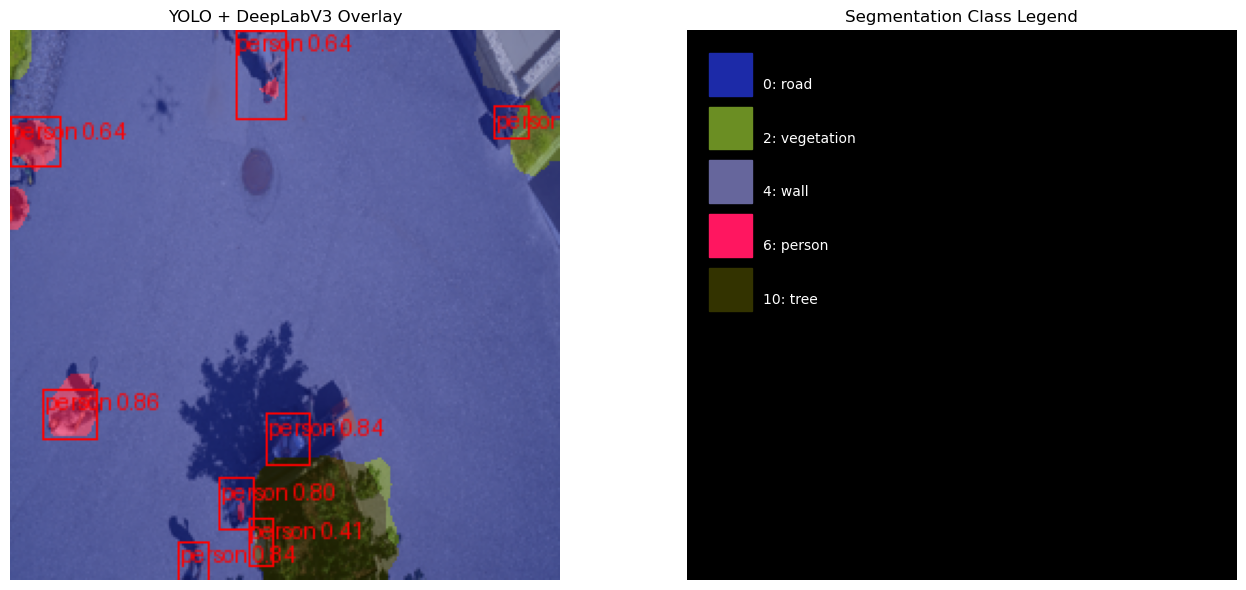

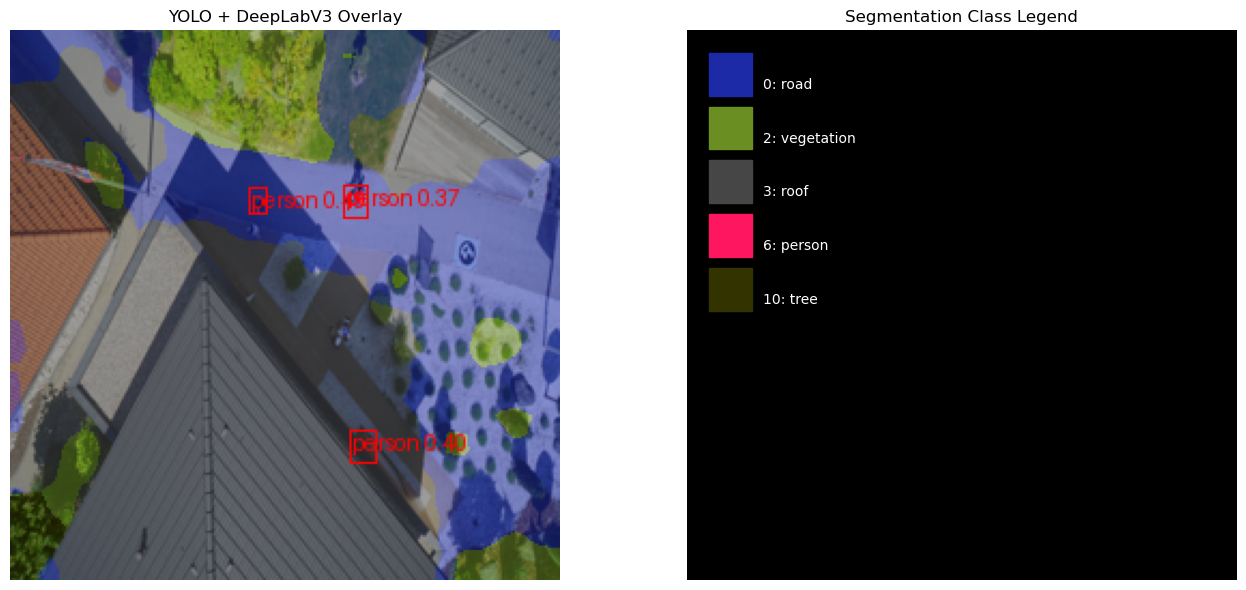

Processing:   0%|          | 0/176 [00:00<?, ?it/s]


0: 384x640 6 persons, 43.9ms
Speed: 2.1ms preprocess, 43.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 50.1ms
Speed: 1.5ms preprocess, 50.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 43.5ms
Speed: 1.5ms preprocess, 43.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.9ms
Speed: 1.6ms preprocess, 39.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.9ms
Speed: 1.5ms preprocess, 38.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 41.1ms
Speed: 1.7ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 42.2ms
Speed: 1.4ms preprocess, 42.2ms inference, 1.1ms postprocess per image at shape

In [58]:
# # Class ID to name mapping with RGB values
class_id_to_name = {
    0: ('road', [28, 42, 168]),
    1: ('pool', [0, 50, 89]),
    2: ('vegetation', [107, 142, 35]),
    3: ('roof', [70, 70, 70]),
    4: ('wall', [102, 102, 156]),
    5: ('window', [254, 228, 12]),
    6: ('person', [255, 22, 96]),
    7: ('dog', [102, 51, 0]),
    8: ('car', [9, 143, 150]),
    9: ('bicycle', [119, 11, 32]),
    10: ('tree', [51, 51, 0]),
}


# Downlaod the datasets

# gdrive_url = "https://drive.google.com/file/d/1UppumYqYOi-kto6BWPfFxwJK2Eph46oY/view?usp=sharing"
# download_and_extract_from_gdrive(gdrive_url, extract_to="datasets")

# # Path to the dataset
# dataset_path = "./datasets/semantic_drone_dataset/training_set"
# output_dir = "./datasets/new_dataset"

# convert_fulldataset(dataset_path, output_dir, class_id_to_name)


# # Path to the new dataset
# dataset_path = "./datasets/new_dataset"
# image_dir = os.path.join(dataset_path, "images")
# segmentation_mask_dir = os.path.join(dataset_path, "segmentation_mask")
# annotations_dir = os.path.join(dataset_path, "labels")

# # Loop through some example image IDs (you can specify more or iterate through the dataset)
# image_ids = [img.split('.')[0] for img in os.listdir(image_dir) if img.endswith(".jpg")]
# for image_id in image_ids[:5]:  # Visualizing first 5 images as an example
#     visualize_data(image_id, class_id_to_name)


# # Define paths for already converted datasets
# input_image_dir = "./datasets/new_dataset/images"
# input_mask_dir = "./datasets/new_dataset/segmentation_mask"
# input_annotation_dir = "./datasets/new_dataset/labels"

# # New folder for final dataset
# output_dir = "./datasets/suitable-dataset"  

# # Create directories for the train and val sets
# train_image_dir = os.path.join(output_dir, 'train/images')
# val_image_dir = os.path.join(output_dir, 'val/images')
# train_mask_dir = os.path.join(output_dir, 'train/segmentation_mask')
# val_mask_dir = os.path.join(output_dir, 'val/segmentation_mask')
# train_annotation_dir = os.path.join(output_dir, 'train/labels')
# val_annotation_dir = os.path.join(output_dir, 'val/labels')

# os.makedirs(train_image_dir, exist_ok=True)
# os.makedirs(val_image_dir, exist_ok=True)
# os.makedirs(train_mask_dir, exist_ok=True)
# os.makedirs(val_mask_dir, exist_ok=True)
# os.makedirs(train_annotation_dir, exist_ok=True)
# os.makedirs(val_annotation_dir, exist_ok=True)

# # List of all image files in the dataset
# image_ids = [img.split('.')[0] for img in os.listdir(input_image_dir) if img.endswith('.jpg')]

# # Split the dataset into train and val using a 80-20 split
# train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
# # Move training files
# move_files(train_ids, input_image_dir, input_mask_dir, input_annotation_dir,
#            train_image_dir, train_mask_dir, train_annotation_dir)

# # Move validation files
# move_files(val_ids, input_image_dir, input_mask_dir, input_annotation_dir,
#            val_image_dir, val_mask_dir, val_annotation_dir)

# print("[+] Dataset split into train and val, and files moved successfully.")

# # Train YOLOv8
# train_yolo(data_yaml="uavdt.yaml")

# # Train Segmentation
# train_segmentation(
#     image_dir='./datasets/suitable-dataset/train/images',
#     mask_dir='./datasets/suitable-dataset/train/segmentation_mask'
# )

# print("[+] Training is Done")

# Load the model
best_pt_path = find_best_pt()


CLASS_COLORS = {k: tuple(np.array(v[1]) / 255.0) for k, v in class_id_to_name.items()}
CLASS_NAMES = {k: v[0] for k, v in class_id_to_name.items()}

deeplab_path = 'deeplabv3_model.pth'
yolo_path = best_pt_path  # <- Update with actual model path

deeplab_model = load_deeplabv3_model(deeplab_path)
yolo_model = load_yolo_model(yolo_path)

test_dir = "./datasets/suitable-dataset/val/images"
test_images = sorted(os.listdir(test_dir))[:2]

for img_file in test_images:
    predict_and_visualize(os.path.join(test_dir, img_file), deeplab_model, yolo_model, CLASS_COLORS, CLASS_NAMES)

num_classes = len(class_id_to_name)
yolo_class_names = [class_id_to_name[i][0] for i in sorted(class_id_to_name)]


# ================== CONFIG ==================
video_path = './video.mp4'
max_frames = None  # Set to None for full video

# ================== RUN ==================
process_video(video_path, yolo_path, deeplab_path, yolo_class_names, class_id_to_name, num_classes, max_frames)
